# Lecture 1 - Introduction to Uncertainty Quantification

> Ignorance is preferable to error and he is less remote from the truth who believes nothing than he who believes what is wrong.
Thomas Jefferson (1781)

## Objectives
+ To tell the difference between **aleatory** and **epistemic** uncertainties.
+ To define **predictive modeling**.
+ To get accustomed with the processes of **verification**, **calibration**, and **validation** of a computer code.
+ To use **probability theory** to represent both aleatory and epistemic uncertainties.

## Readings

Before coming to class, please read the following:

+ \cite{oden2010a}.

+ \cite{oden2010b}.

## Definitions

We are not going to make a big effort to be consistent about the use of the following terms, since their precise meaning is still under debate.

### Uncertainty
In general, we are uncertain about a logical proposition if we do not know whether it is true or false. 
In particular, we can be uncertain about:
+ the value of a model parameter
+ the mathematical form of a model
+ the initial conditions of a ordinary differntial equations
+ the boundary conditions of a partial differential equation
+ the value of an experimental measurment we are about to perform
+ etc.

Uncertainty may be *aleatory* or *epistemic*. Aleatory uncertainty is associated with inherent system randomness. Epistemic uncertainty is associated with lack of knowledge. If you think too hard, the distinction between the two becomes philosophical. We are not going to push this too hard. Fortunately, our approach (the Bayesian approach) treats both uncertainty on an equal footing.

### Predictive Modeling
*Predictive modeling* is the process of assigning error bars to the predictions of computational models which rigorously quantify the effect of all (ideally) associated uncertainties. This quantified uncertainty can be used to assess the risk of making decisions based on these model predictions.

### Verification
Verification is the process of *convincing yourself* that a computer code is actually solving the right mathematical equations. Even though it is impossible to be 100% sure that a complicated computer code works as intended, it is easy to verify that it does not.

### Calibration
Calibration is the process of fitting the parameters of a computer code to experimental data. It is most important problem of uncertainty quantification. The difficulties arise from the experimental noise, insufficient data (observing part of the system), model discrepancy and more.

### Validation
Validation is the process of comparing the model predictions to experimental data not used in the calibration process.


## Example: Catalytic Conversion of Nitrate to Nitrogen

This is Example 3.1 of \cite{tsilifis2015}.

Consider the catalytic
conversion of nitrate ($\mbox{NO}_3^-$) to nitrogen ($\mbox{N}_2$) and other
by-products by electrochemical means.
The mechanism that is followed is complex and not well understood.
The experiment of \cite{katsounaros} confirmed the
production of nitrogen ($\mbox{N}_2$), ammonia
($\mbox{NH}_3$), and nitrous oxide ($\mbox{N}_2\mbox{O}$) as final products
of the reaction, as well as the intermediate production of nitrite ($\mbox{NO}_2^-$).
The data are reproduced in [Comma-separated values](https://en.wikipedia.org/wiki/Comma-separated_values) (CSV) and stored in
[data/catalysis.csv](data/catalysis.csv).
The time is measured in minutes and the conentrations are measured in $\mbox{mmol}\cdot\mbox{L}^{-1}$.
Let's load the data into this notebook using the [Pandas](http://pandas.pydata.org) Python module:


In [15]:
import pandas as pd
catalysis_data = pd.read_csv('../data/catalysis.csv', index_col=0)
catalysis_data

,NO3,NO2,N2,NH3,N2O
Time,,,,,
0,500.00,0.00,0.00,0.00,0.00
30,250.95,107.32,18.51,3.33,4.98
60,123.66,132.33,74.85,7.34,20.14
90,84.47,98.81,166.19,13.14,42.10
120,30.24,38.74,249.78,19.54,55.98
150,27.94,10.42,292.32,24.07,60.65
180,13.54,6.11,309.50,27.26,62.54


Let's visualize the data using [Matplotlib](http://matplotlib.org):

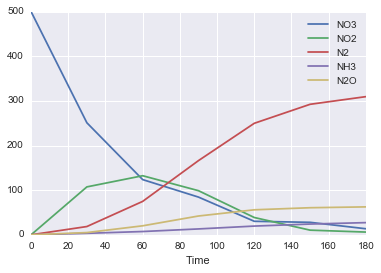

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
catalysis_data.plot()

The theory of catalytic reactions guarantees that the total mass must be conserved.
However, this is not the case in our dataset:

In [17]:
catalysis_data.sum(axis=1)

Time
0      500.00
30     385.09
60     358.32
90     404.71
120    394.28
150    415.40
180    418.95
dtype: float64

This inconsistency suggests the existence of an intermediate unobserved reaction product X.
\cite{katsounaros} suggested that the following reaction path shown in the following figure.

![](figures/scheme.png "Reaction Scheme")

The dynamical system associated with the reaction is:
\begin{equation}
\begin{array}{cc}
\frac{d \left[\mbox{NO}_3^-\right]}{dt} &= -k_1\left[\mbox{NO}_3^-\right], \\
\frac{d\left[\mbox{NO}_2^-\right]}{dt} &= k_1\left[\mbox{NO}_3^-\right] - (k_2 + k_4 +
k_5)[\mbox{NO}_2^-], \\
\frac{d \left[\mbox{X}\right]}{dt} &= k_2 \left[\mbox{NO}_2^-\right] - k_3 [X],\\
\frac{d \left[\mbox{N}_2\right]}{dt} &= k_3 \left[\mbox{X}\right], \\
\frac{d \left[\mbox{NH}_3\right]}{dt} &= k_4 \left[\mbox{NO}_2^-\right],\\
\frac{d \left[\mbox{N}_2O\right]}{dt} &= k_5 \left[\mbox{NO}_2^-\right],
\end{array}
\label{eq:kinetic_model}
\end{equation}
where $[\cdot]$ denotes the concentration of a quantity, and
$k_i > 0$, $i=1,...5$ are the *kinetic rate constants*.


### Questions

1) Assume that you are a chemical engineer and that you are assigned the task of designing a reactor for the conversion of nitrate to nitrogen. Before you start designing, you collect on information in an attempt to characterize your state of knowledge about the problem. How many different sources of uncertainty can you think of?

2) Which of these uncertainties would you characterize as aleatoric uncertainties and which as epistemic?

3) Is the distinction between aleatory and epistemic uncertainties always clear cut?

### Computational Model

We will develop a generic computational model for the solution of dynamical systems and we will use it to study the catalysis problem. The code relies on the [Fourth-order Runge-Kutta method](https://en.wikipedia.org/wiki/Runge–Kutta_methods) and is a modified copy of [http://www.math-cs.gordon.edu/courses/ma342/python/diffeq.py](http://www.math-cs.gordon.edu/courses/ma342/python/diffeq.py) developed by Jonathan Senning. The code solves:

\begin{equation}
\label{eq:ode}
\begin{array}{ccc}
\dot{\mathbf{y}} &=& f(\mathbf{y}, t),\\
\mathbf{y}(0) &=& \mathbf{y}_0.
\end{array}
\end{equation}

In [18]:
import numpy as np
def rk45( f, y0, t, args=() ):
    """Fourth-order Runge-Kutta method with error estimate.

    USAGE:
        y = rk45(f, x0, t, args=())

    INPUT:
        f     - function of x and t equal to dx/dt.  x may be multivalued,
                in which case it should a list or a NumPy array.  In this
                case f must return a NumPy array with the same dimension
                as x.
        y0    - the initial condition(s).  Specifies the value of x when
                t = t[0].  Can be either a scalar or a list or NumPy array
                if a system of equations is being solved.
        t     - list or NumPy array of t values to compute solution at.
                t[0] is the the initial condition point, and the difference
                h=t[i+1]-t[i] determines the step size h.
        args  - any other parameters of the function f.

    OUTPUT:
        y     - NumPy array containing solution values corresponding to each
                entry in t array.  If a system is being solved, x will be
                an array of arrays.

    NOTES:
        This version is based on the algorithm presented in "Numerical
        Mathematics and Computing" 6th Edition, by Cheney and Kincaid,
        Brooks-Cole, 2008.
    """

    # Coefficients used to compute the independent variable argument of f

    c20  =   2.500000000000000e-01  #  1/4
    c30  =   3.750000000000000e-01  #  3/8
    c40  =   9.230769230769231e-01  #  12/13
    c50  =   1.000000000000000e+00  #  1
    c60  =   5.000000000000000e-01  #  1/2

    # Coefficients used to compute the dependent variable argument of f

    c21 =   2.500000000000000e-01  #  1/4
    c31 =   9.375000000000000e-02  #  3/32
    c32 =   2.812500000000000e-01  #  9/32
    c41 =   8.793809740555303e-01  #  1932/2197
    c42 =  -3.277196176604461e+00  # -7200/2197
    c43 =   3.320892125625853e+00  #  7296/2197
    c51 =   2.032407407407407e+00  #  439/216
    c52 =  -8.000000000000000e+00  # -8
    c53 =   7.173489278752436e+00  #  3680/513
    c54 =  -2.058966861598441e-01  # -845/4104
    c61 =  -2.962962962962963e-01  # -8/27
    c62 =   2.000000000000000e+00  #  2
    c63 =  -1.381676413255361e+00  # -3544/2565
    c64 =   4.529727095516569e-01  #  1859/4104
    c65 =  -2.750000000000000e-01  # -11/40

    # Coefficients used to compute 4th order RK estimate

    a1  =   1.157407407407407e-01  #  25/216
    a2  =   0.000000000000000e-00  #  0
    a3  =   5.489278752436647e-01  #  1408/2565
    a4  =   5.353313840155945e-01  #  2197/4104
    a5  =  -2.000000000000000e-01  # -1/5

    b1  =   1.185185185185185e-01  #  16.0/135.0
    b2  =   0.000000000000000e-00  #  0
    b3  =   5.189863547758284e-01  #  6656.0/12825.0
    b4  =   5.061314903420167e-01  #  28561.0/56430.0
    b5  =  -1.800000000000000e-01  # -9.0/50.0
    b6  =   3.636363636363636e-02  #  2.0/55.0

    n = len( t )
    y = np.array( [ y0 ] * n )
    for i in xrange( n - 1 ):
        h = t[i+1] - t[i]
        k1 = h * f( y[i], t[i], *args )
        k2 = h * f( y[i] + c21 * k1, t[i] + c20 * h, *args )
        k3 = h * f( y[i] + c31 * k1 + c32 * k2, t[i] + c30 * h, *args )
        # BUG: The ``-`` in the equation below should be a ``+``.
        k4 = h * f( y[i] + c41 * k1 + c42 * k2 + c43 * k3, t[i] + c40 * h, *args )
        k5 = h * f( y[i] + c51 * k1 + c52 * k2 + c53 * k3 + c54 * k4, \
                        t[i] + h, *args )
        k6 = h * f( \
            y[i] + c61 * k1 + c62 * k2 + c63 * k3 + c64 * k4 + c65 * k5, \
            t[i] + c60 * h, *args )

        y[i+1] = y[i] + a1 * k1 + a3 * k3 + a4 * k4 + a5 * k5
        y5 = y[i] + b1 * k1 + b3 * k3 + b4 * k4 + b5 * k5 + b6 * k6

    return y

### Code Verification
It is obvious that even a small typo in the code above will have a significant impact in the solution. How do we know that the code actually solves Eq. (\ref{eq:ode})? Well, we can't... However, we can convince ourselves about it. We need to find a case of Eq. (\ref{eq:ode}) with a known solution. Consider the ODE governing a forced harmonic oscillator:
\begin{equation}
\begin{array}{ccl}
\ddot{y} &=& -k y + A\sin(\omega t),\\
y(0) &=& 0,\\
\dot{y}(0) &=& 1.
\end{array}
\end{equation}
This can be solved analytically. Let's use [SymPy](http://docs.sympy.org/dev/index.html) to solve it:

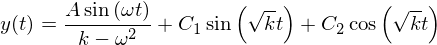

In [19]:
import sympy
from sympy import init_printing
init_printing()
from sympy import Function, dsolve, Eq, Derivative, sin, symbols
from sympy.abc import t
t, k, A, omega = sympy.symbols('t k A omega', real = True, positive = True)
y = Function('y')
generic_solution = dsolve(Derivative(y(t), t, t) + k * y(t) - A * sin(omega * t), y(t))
generic_solution

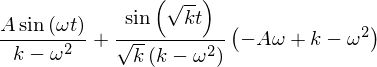

In [20]:
# Apply the initial conditions
constants = sympy.solve((generic_solution.rhs.subs(t, 0), generic_solution.rhs.diff(t).subs(t, 0) - 1), ('C1', 'C2'))
solution = generic_solution.rhs.subs(constants)
solution

In [21]:
# Turn this into a Python function that we can actually evaluate
from sympy.utilities.autowrap import ufuncify
y_true = ufuncify([t, k, A, omega], solution)

To solve this initial value problem numerically using ``rk45``, we must first turn it into a system. This is done by setting $y_1 = y$ and $y_2 = \dot{y_1}$:
\begin{equation}
\begin{array}{ccl}
\dot{y}_1 &=& y_2,\\
\dot{y}_2 &=& -k y_1 + A\sin(\omega t),\\
y_1(0) &=& 0,\\
y_2(0) &=& 1.
\end{array}
\end{equation}
Thus $\mathbf{f}(\mathbf{y}, t) := \mathbf{f}(y_1, y_2, t;k, A, \omega) = (y_2, -k y_1 + A \sin(\omega t))$.

In [22]:
def f(y, t, k, A, omega):
    """
    RHS of the ODE we want to solve.
    
    k, A, and omega are model parameters.
    """
    return np.array([y[1], -k * y[0] + A * np.sin(omega * t)])

def plot_ode_sol(T = 30., k = 0.5, A = 1., omega = 2., nt = 10):
    """
    Compare the numerical solution to the analytical one.
    """
    t = np.linspace(0, T, int(nt))
    y = rk45(f, (0., 1.), t, args=(k, A, omega))
    plt.plot(t, y[:, 0], label='Numerical solution')
    plt.plot(t, y_true(t, k, A, omega), '--', label='Analytical solution')
    plt.legend()

Use the [interactive widget](https://github.com/ipython/ipywidgets) below to verify that our code acutally solves the right mathematical equations.

### Questions
4) Can you verify (using the widget below) that our code solves the right mathematical equation?

5) If you can't, skim through the code of ``rk45`` to find a BUG and fix it. It should be fairly easy. The rerun the cell defininig the solver and play with the widget again.

5) What is the parameter that controls the accuracy of the solution?

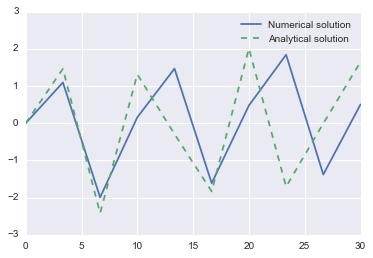

In [23]:
from ipywidgets import interactive
interactive(plot_ode_sol, T = (20, 100), k = [0., 1.], A = [0., 2.], omega = [0., 2], nt = [10, 100])

## Calibrating the Catalysis Model to the Experimental Data

Now that we are certain that our generic ODE solver works, let us use it to develop a solver for the catalysis model. All, we need to do is define the right hand side of Eq. (\ref{eq:kinetic_model}):

In [24]:
def f_catalysis(y, t, kappa):
    rhs = np.zeros((6,))
    rhs[0] = -kappa[0] * y[0]
    rhs[1] = kappa[0] * y[0] - (kappa[1] + kappa[3] + kappa[4]) * y[1]
    rhs[2] = kappa[1] * y[1] - kappa[2] * y[2]
    rhs[3] = kappa[2] * y[2]
    rhs[4] = kappa[3] * y[1]
    rhs[5] = kappa[4] * y[1]
    return rhs

Let's try to calibrate the parameters of the model to the data, manually. Because the parameters are two small, let us work with the transformed version:

$$
\xi_i = \log\left(\frac{k_i}{180}\right).
$$

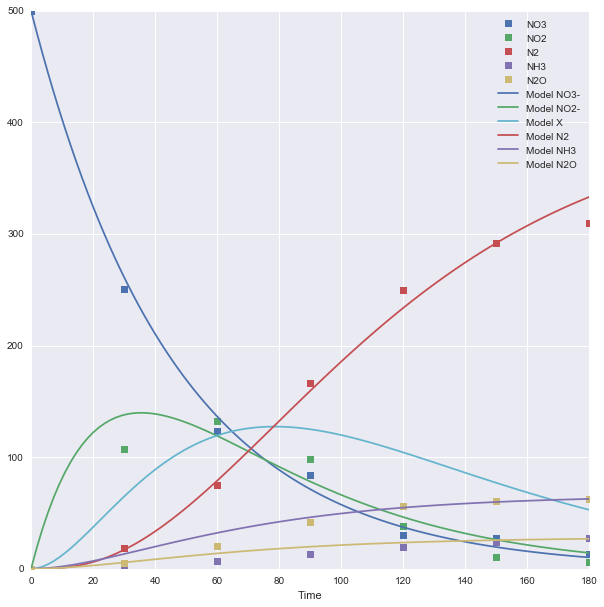

In [25]:
def compare_model_to_data(xi1 = 1.359, xi2 = 1.657, xi3 = 1.347, xi4 = -.162, xi5 = -1.009):
    """
    Compare the model predictions to the data.
    """
    t = np.linspace(0, 180, 100)
    kappa = np.exp([xi1, xi2, xi3, xi4, xi5]) / 180.
    y = rk45(f_catalysis, (500., 0., 0., 0., 0., 0.), t, args=(kappa,))
    fig, ax = plt.subplots(figsize=(10, 10))
    catalysis_data.plot(ax=ax, style='s')
    ax.plot(t, y[:, 0], color=sns.color_palette()[0], label='Model NO3-')
    ax.plot(t, y[:, 1], color=sns.color_palette()[1], label='Model NO2-')
    ax.plot(t, y[:, 2], color=sns.color_palette()[5], label='Model X')
    ax.plot(t, y[:, 3], color=sns.color_palette()[2], label='Model N2')
    ax.plot(t, y[:, 4], color=sns.color_palette()[3], label='Model NH3')
    ax.plot(t, y[:, 5], color=sns.color_palette()[4], label='Model N2O')
    plt.legend()
    
interactive(compare_model_to_data, xi1 = (-2, 2, 0.05), xi2 = (-2, 2, 0.05), xi3 = (-2, 2, 0.05),
                                   xi4 = (-2, 2, 0.05), xi5 = (-2, 2, 0.05) )

This is the calibration problem. 

### Questions

1) Obviously, you do not want to be calibrating models by hand. Can you think of a *natural* way to calibrate a model?

2) No matter what we do, we cannot really match the data to the model exactly? List at least two reasons why this is the case?

### Uncertainty Propagation

As discussed in Question 2 above, there various reasons why a model cannot be calibrated perfectly. Some of these are:

+ lack of data;
+ the existence of measurement noise;
+ the fact that the model is just not perfect.

Ignoring for the moment the possibility that the moment is just bluntly wrong, we see that the lack of data or the presence of noise will induce some uncertainty in the values of the calibrated parameters. We are going to represent uncertainty on parameters by assigning a probability density on them. There are systematic ways of estimating the uncertainty induced because of the calibration process, but this will not concern us now.
For the moment, assume that somebody told us that the uncertainty in the scaled parameters $\xi_i$ of the model is as follows:


| Variable | Value |
|---------|------------------|
| $\xi_1$ |$1.35\pm 0.05$ |
| $\xi_2$ |$1.65\pm 0.08$   |
| $\xi_3$ |$1.34\pm 0.11$ |
| $\xi_4$ |$-0.16\pm 0.16$ |
| $\xi_5$ |$-3.84\pm 0.20$ |

But what does this information actually mean? As we will discuss in the following lectures, this information can be used to assign a probability density on each one of these parameters, say $p(\xi_i)$, that *models* our state of knowledge about them. For example, let us assume that our state of knowledge about $\xi_1$ is given by a Gaussian probability density:

$$
p(\xi_1) = \mathcal{N}(\xi_1|\mu_1=1.35, \sigma^2 = 0.05^2),
$$

which we can visualize as follows:

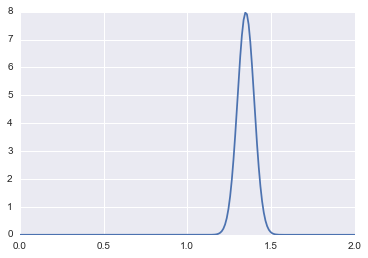

In [26]:
import scipy.stats
from scipy.stats import norm
xi1 = np.linspace(-0, 2, 200)
plt.plot(xi1, norm.pdf(xi1, loc=1.35, scale=0.05))

This means that we do not beleive that the value of the parameter can be less than 1.0 or greater than 1.6. Note that, we are deliberately trying to avoid the use of the term "random". There is nothing random in our example. Probability models a state of knowledge.

How does this uncertainty propagate throw the model? We will study this question with a simple numerical experiment. We are going to assign Gaussian probability densities on all the $\xi_i$'s, sample them a few times, and run our catalysis model for each one.

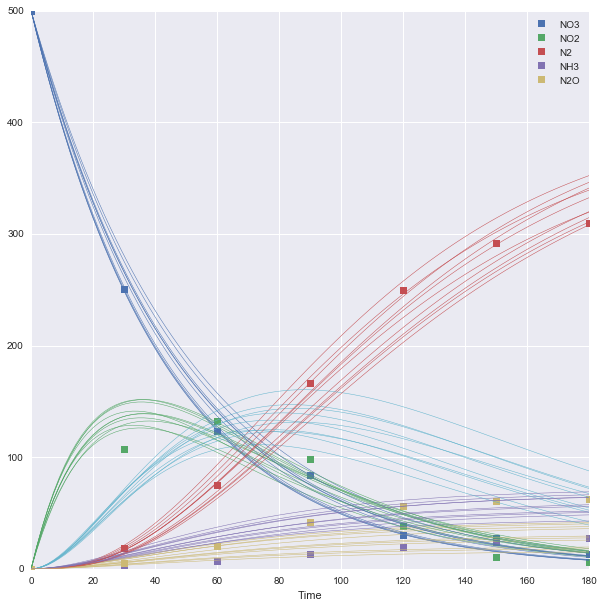

In [27]:
def plot_samples(mu1 = 1.359, sig1=0.055,
                mu2 = 1.657, sig2=0.086,
                mu3 = 1.347, sig3=0.118,
                mu4 = -.162, sig4=0.167,
                mu5 = -1.009, sig5=0.368,
                num_samples=10):
    """
    Take a few samples of the model to study uncertainty propagation.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    catalysis_data.plot(ax=ax, style='s')
    t = np.linspace(0, 180, 100)
    for i in xrange(num_samples):
        xi1 = norm.rvs(loc=mu1, scale=sig1)
        xi2 = norm.rvs(loc=mu2, scale=sig2)
        xi3 = norm.rvs(loc=mu3, scale=sig3)
        xi4 = norm.rvs(loc=mu4, scale=sig4)
        xi5 = norm.rvs(loc=mu5, scale=sig5)
        kappa = np.exp([xi1, xi2, xi3, xi4, xi5]) / 180.
        y = rk45(f_catalysis, (500., 0., 0., 0., 0., 0.), t, args=(kappa,))
        ax.plot(t, y[:, 0], linewidth=0.5, color=sns.color_palette()[0])#, label='Model NO3-')
        ax.plot(t, y[:, 1], linewidth=0.5, color=sns.color_palette()[1])#, label='Model NO2-')
        ax.plot(t, y[:, 2], linewidth=0.5, color=sns.color_palette()[5])#, label='Model X')
        ax.plot(t, y[:, 3], linewidth=0.5, color=sns.color_palette()[2])#, label='Model N2')
        ax.plot(t, y[:, 4], linewidth=0.5, color=sns.color_palette()[3])#, label='Model NH3')
        ax.plot(t, y[:, 5], linewidth=0.5, color=sns.color_palette()[4])#, label='Model N2O')
    plt.legend()

interactive(plot_samples, mu1 = (-2, 2, 0.05), sig1=(0.02, 0.4, 0.01),
                                   mu2 = (-2, 2, 0.05), sig2=(0.02, 0.4, 0.01),
                                   mu3 = (-2, 2, 0.05), sig3=(0.02, 0.4, 0.01),
                                   mu4 = (-2, 2, 0.05), sig4=(0.02, 0.4, 0.01),
                                   mu5 = (-2, 2, 0.05), sig5=(0.02, 0.4, 0.01))

### Questions

1) It was pretty easy to propagate uncertainty through this simple model. When would you face difficulties with such a program?

2) Can you come up with any idea of accelerating the uncertainty propagation process?

# References

[<a id="cit-oden2010a" href="#call-oden2010a">1</a>] Tinsley Oden, Robert Moser and Omar Ghattas, ``Computer Predictions with Quantified Uncertainty, Part I'', The Institute for Computational Engineering and Sciences, number: ,  October 2010.  [online](http://www.siam.org/pdf/news/1842.pdf)

[<a id="cit-oden2010b" href="#call-oden2010b">2</a>] Tinsley Oden, Robert Moser and Omar Ghattas, ``Computer Predictions with Quantified Uncertainty, Part II'', The Institute for Computational Engineering and Sciences, number: ,  October 2010.  [online](http://www.siam.org/pdf/news/1857.pdf)

[<a id="cit-tsilifis2015" href="#call-tsilifis2015">3</a>] Tsilifis P., Bilionis I., Katsounaros I <em>et al.</em>, ``_Variational reformulation of Bayesian inverse problems_'', ASME Journal of Verification and Validation (submitted), vol. , number , pp. ,  2015.  [online](http://arxiv.org/abs/1410.5522)

[<a id="cit-katsounaros" href="#call-katsounaros">4</a>] Katsounaros I, Dortsiou M, Polatides C <em>et al.</em>, ``_Reaction pathways in the electrochemical reduction of nitrate on tin_'', Electrochimica Acta, vol. 71, number , pp. 270--276,  2012.

